In [ ]:
import surprise
import implicit
from surprise import accuracy
from surprise import SVD
from surprise.model_selection import PredefinedKFold
import scipy.sparse as sp
from sklearn.decomposition import NMF
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Listas de Recomendaciones

In [ ]:
reader = surprise.Reader(line_format='user item rating', sep=',', rating_scale=(1, 5), skip_lines=1)
data = surprise.Dataset.load_from_folds([('train', 'test')], reader=reader)
pkf = PredefinedKFold()
trainset, testset = next(pkf.split(data))

In [ ]:
df_train = pd.read_csv(
    "train", sep=",", names=["userid", "itemid", "rating"], header=None
)

df_train.rating = [1 if x >= 5 else 0 for x in df_train.rating]

df_train.head()

,userid,itemid,rating
0,2052,12445.0,1
1,5141,34599.0,1
2,3340,37510.0,1
3,588,853.0,1
4,4822,27775.0,1


In [ ]:
df_test = pd.read_csv(
    "test", sep=",", names=["userid", "itemid", "rating"], header=None
)

df_test.rating = [1 if x >= 5 else 0 for x in df_test.rating]

df_test.head()

,userid,itemid,rating
0,18887,37450.0,1
1,8831,32379.0,0
2,37283,36882.0,1
3,35602,10490.0,1
4,39042,NaN,1


In [ ]:
user_items_test = {}

for row in df_test.itertuples():
    if row[1] not in user_items_test:
        user_items_test[row[1]] = []

    user_items_test[row[1]].append(row[2])

In [ ]:
item_interaction_counts = df_train['itemid'].value_counts()
user_count = df_train['userid'].nunique()
item_popularity = (item_interaction_counts / user_count).to_dict()

In [ ]:
metadata = animes[['uid', 'genre']]
item_categories: dict[int, set[str | None]] = {}
for row in metadata.itertuples():
    item_categories[int(row[1]) if row[1].is_integer() else row[1]] = set(map(lambda i: i.strip(), row[2].split(','))) if isinstance(row[2], str) else set()

from metrics import precision_at_k, ndcg_at_k, novelty, diversity, recall_at_k, average_precision_at_k

In [ ]:
user_items = {}
itemset = set()

for row in df_train.itertuples():
    if row[1] not in user_items:
        user_items[row[1]] = []

    user_items[row[1]].append(row[2])
    itemset.add(row[2])

itemset = np.sort(list(itemset))

sparse_matrix = np.zeros((len(user_items), len(itemset)))

for i, items in enumerate(user_items.values()):
    sparse_matrix[i] = np.isin(itemset, items, assume_unique=True).astype(int)

matrix = sp.csr_matrix(sparse_matrix.T)

user_item_matrix = matrix.T.tocsr()

In [ ]:
user2row = {user_id: matrix_row for matrix_row, user_id in enumerate(user_items.keys())}
row2user = {matrix_row: user_id for user_id, matrix_row in user2row.items()}

item2col = {item_id: matrix_col for matrix_col, item_id in enumerate(itemset)}
col2item = {matrix_col: item_id for item_id, matrix_col in item2col.items()}

In [ ]:
animes['popularity_score'] = (
                (1 / animes['popularity']) * 0.4 +
                (1 / animes['ranked'].fillna(10000)) * 0.3 +
                animes['score'] * 0.3
            )
popular_animes = animes.sort_values('popularity_score', ascending=False)

In [ ]:
class ModelWrapper:
    def __init__(self, model):
        self.model = model
        # if model == "most_popular":
        #     self.most_popular = AnimeMostPopularRecommender(popularity_metric="weighted")
        #     self.most_popular.fit(animes)

    def recommend(self, user_id, user_item_matrix, n=10):
        if self.model == "random":
            seen = set(user_items.get(user_id, []))
            item_array = np.array(list(itemset))
            mask = ~np.isin(item_array, list(seen))
            candidates = item_array[mask]
            return np.random.choice(candidates, size=n, replace=False)

        if self.model == "most_popular":
            seen = set(user_items.get(user_id, []))
            recommendations = []
            for _, anime in popular_animes.iterrows():
                if anime['uid'] not in seen:
                    recommendations.append(anime['uid'])
                if len(recommendations) >= n:
                    break
            return recommendations

        if hasattr(self.model, 'recommend') and callable(getattr(self.model, 'recommend')):
            try:
                user_row = user2row[user_id]
                rec = self.model.recommend(user_row, user_item_matrix[user_row], n)[0]
                return np.array([col2item[col] for col in rec])
            except KeyError:
                # Fallback a Most Popular
                # print(f"User {user_id} not in user2row, using most popular fallback")
                seen = set(user_items.get(user_id, []))
                recommendations = []
                for _, anime in popular_animes.iterrows():
                    if anime['uid'] not in seen:
                        recommendations.append(anime['uid'])
                    if len(recommendations) >= n:
                        break
                return recommendations

        else:
            trainset = self.model.trainset
            u = trainset.to_inner_uid(str(user_id))

            pu = self.model.pu[u]
            bu = self.model.bu[u]
            qi = self.model.qi
            bi = self.model.bi
            mu = trainset.global_mean

            scores = mu + bu + bi + qi @ pu

            known_items = set([j for (j, _) in trainset.ur[u]])
            scores[list(known_items)] = -np.inf

            top_n_idx = np.argpartition(scores, -n)[-n:]
            top_n_idx = top_n_idx[np.argsort(scores[top_n_idx])[::-1]]

            return np.array([int(trainset.to_raw_iid(i)) for i in top_n_idx])

In [ ]:
def evaluate_model(model, n):
    mean_recall = 0.0
    mean_ap = 0.0
    mean_ndcg = 0.0
    mean_novelty = 0.0
    mean_diversity = 0.0
    for user_id in user_items_test.keys():
        rec = ModelWrapper(model).recommend(user_id, user_item_matrix, n)
        rel_vector = np.isin(rec, user_items_test[user_id], assume_unique=True).astype(int)
        mean_recall += recall_at_k(rel_vector, n)
        mean_ap += average_precision_at_k(rel_vector, n)
        mean_ndcg += ndcg_at_k(rel_vector, n)
        mean_novelty += novelty(rec, item_popularity)
        mean_diversity += diversity(rec, n, item_categories)

    mean_recall /= len(user_items_test)
    mean_ap /= len(user_items_test)
    mean_ndcg /= len(user_items_test)
    mean_novelty /= len(user_items_test)
    mean_diversity /= len(user_items_test)

    return mean_recall, mean_ap, mean_ndcg, mean_novelty, mean_diversity

In [ ]:
def plot_results(results, xlabel, title):
    df = pd.DataFrame(results, columns=["K", "Recall", "MAP", "nDCG", "Novelty", "Diversity"])

    max_info = np.log2(len(itemset))
    df["Novelty (norm)"] = (df["Novelty"] / max_info)

    plt.figure(figsize=(6,4))
    for metric in ["Recall", "MAP", "nDCG"]:
        plt.plot(df["K"], df[metric], marker="o", label=metric)

    plt.xlabel(xlabel)
    plt.ylabel("Score")
    plt.title(title)
    plt.legend()
    plt.grid()

    plt.figure(figsize=(6,4))
    for metric in ["Novelty (norm)", "Diversity"]:
        plt.plot(df["K"], df[metric], marker="o", label=metric)

    plt.xlabel(xlabel)
    plt.ylabel("Score")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

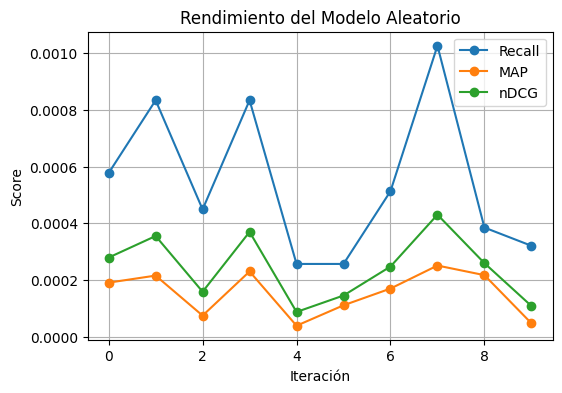

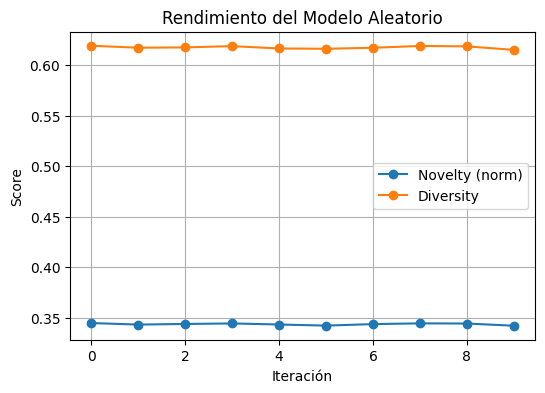

In [ ]:
results_rnd = []

for i in range(10):
    model_rnd = "random"
    recall_rnd, map_rnd, mndcg_rnd, novelty_rnd, diversity_rnd = evaluate_model(model_rnd, 10)
    results_rnd.append([i, recall_rnd, map_rnd, mndcg_rnd, novelty_rnd, diversity_rnd])

plot_results(results_rnd, "Iteración", "Rendimiento del Modelo Aleatorio")

In [ ]:
results_mp = []

# for i in range(10):
model_mp = "most_popular"
recall_mp, map_mp, mndcg_mp, novelty_mp, diversity_mp = evaluate_model(model_mp, 10)
results_mp.append([i, recall_mp, map_mp, mndcg_mp, novelty_mp, diversity_mp])

# plot_results(results_mp, "Iteración", "Rendimiento del Modelo MostPopular")
print(f"Recall: {recall_mp}")
print(f"MAP: {map_mp}")
print(f"nDCG: {mndcg_mp}")
print(f"Novelty: {novelty_mp}")
print(f"Diversity: {diversity_mp}")

# De aqui para abajo no funciona xd

50


c:\Users\benja\Documents\Universidad\2025-2\Recomendadores\Proyecto\.venv\Lib\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0010020732879638672 seconds
  warnings.warn(


100


c:\Users\benja\Documents\Universidad\2025-2\Recomendadores\Proyecto\.venv\Lib\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0 seconds
  warnings.warn(


150
200
250
300
350
400
450
500


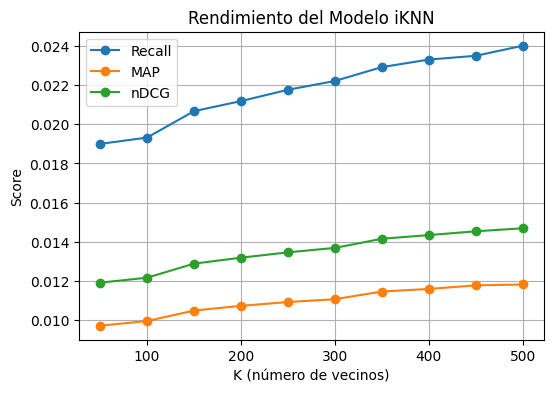

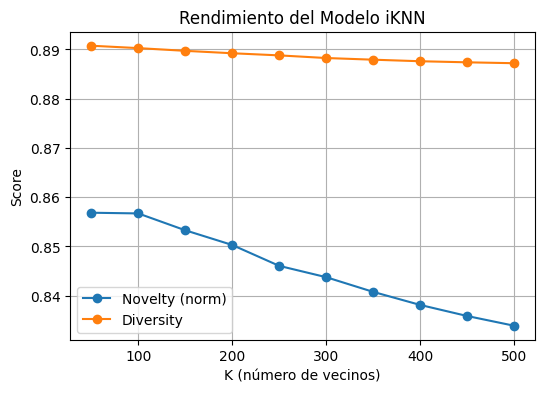

In [ ]:
k_values = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
results_iknn = []

for k in k_values:
    print(k)
    model_iknn = implicit.nearest_neighbours.CosineRecommender(K=k)
    model_iknn.fit(user_item_matrix, show_progress=False)
    recall_iknn, map_iknn, mndcg_iknn, novelty_iknn, diversity_iknn = evaluate_model(model_iknn, 10)
    results_iknn.append([k, recall_iknn, map_iknn, mndcg_iknn, novelty_iknn, diversity_iknn])

plot_results(results_iknn, "K (número de vecinos)", "Rendimiento del Modelo iKNN")

In [ ]:
factor_values = [5, 10, 30, 50, 70, 100, 150, 200, 250, 300]
results_svd = []

for f in factor_values:
    model_svd = SVD(n_factors=f)
    model_svd.fit(trainset)
    recall_svd, map_svd, mndcg_svd, novelty_svd, diversity_svd = evaluate_model(model_svd, 10)
    results_svd.append([f, recall_svd, map_svd, mndcg_svd, novelty_svd, diversity_svd])

plot_results(results_svd, "Número de factores latentes", "Rendimiento del Modelo FunkSVD")

ValueError: invalid literal for int() with base 10: '4181.0'

c:\Users\benja\Documents\Universidad\2025-2\Recomendadores\Proyecto\.venv\Lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: OpenBLAS is configured to use 12 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


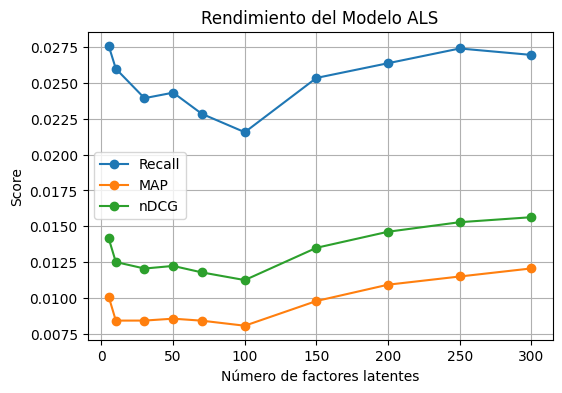

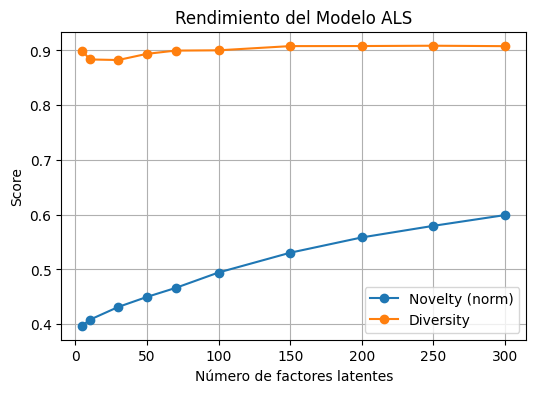

In [ ]:
factor_values = [5, 10, 30, 50, 70, 100, 150, 200, 250, 300]
results_als = []

for f in factor_values:
    model_als = implicit.als.AlternatingLeastSquares(factors=f)
    model_als.fit(user_item_matrix, show_progress=False)
    recall_als, map_als, mndcg_als, novelty_als, diversity_als = evaluate_model(model_als, 10)
    results_als.append([f, recall_als, map_als, mndcg_als, novelty_als, diversity_als])

plot_results(results_als, "Número de factores latentes", "Rendimiento del Modelo ALS")

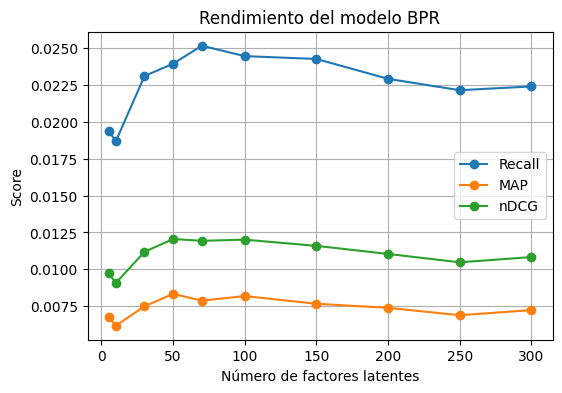

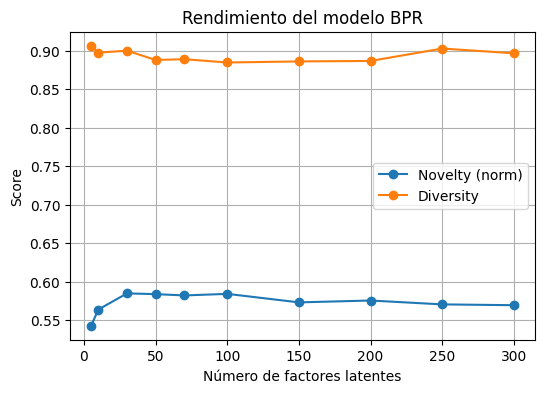

In [ ]:
factor_values = [5, 10, 30, 50, 70, 100, 150, 200, 250, 300]
results_bpr = []

for f in factor_values:
    model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=f)
    model_bpr.fit(user_item_matrix, show_progress=False)
    recall_bpr, map_bpr, mndcg_bpr, novelty_bpr, diversity_bpr = evaluate_model(model_bpr, 10)
    results_bpr.append([f, recall_bpr, map_bpr, mndcg_bpr, novelty_bpr, diversity_bpr])

plot_results(results_bpr, "Número de factores latentes", "Rendimiento del modelo BPR")

In [ ]:
def best_performing_by_rank_metrics(results):
    best_model = max(results, key=lambda x: x[1] * 0.2 + x[2] * 0.4 + x[3] * 0.4)
    return best_model

def best_performing_by_novelty_diversity(results):
    best_model = max(results, key=lambda x: (x[4] / np.log2(len(itemset))) * 0.5 + x[5] * 0.5)
    return best_model

In [ ]:
i, recall_rnd, map_rnd, ndcg_rnd, novelty_rnd, diversity_rnd = best_performing_by_rank_metrics(results_rnd)
k, recall_iknn, map_iknn, ndcg_iknn, novelty_iknn, diversity_iknn = best_performing_by_rank_metrics(results_iknn)
f_svd, recall_svd, map_svd, ndcg_svd, novelty_svd, diversity_svd = best_performing_by_rank_metrics(results_svd)
f_als, recall_als, map_als, ndcg_als, novelty_als, diversity_als = best_performing_by_rank_metrics(results_als)
f_bpr, recall_bpr, map_bpr, ndcg_bpr, novelty_bpr, diversity_bpr = best_performing_by_rank_metrics(results_bpr)

In [ ]:
rows = [
    [f"RANDOM ({i})", recall_rnd, map_rnd, mndcg_rnd, novelty_rnd, diversity_rnd],
    [f"iKNN ({k})", recall_iknn, map_iknn, mndcg_iknn, novelty_iknn, diversity_iknn],
    [f"SVD ({f_svd})", recall_svd, map_svd, mndcg_svd, novelty_svd, diversity_svd],
    [f"ALS ({f_als})", recall_als, map_als, mndcg_als, novelty_als, diversity_als],
    [f"BPR ({f_bpr})", recall_bpr, map_bpr, mndcg_bpr, novelty_bpr, diversity_bpr],
]
print(tabulate(rows, headers=["Modelo", "RECALL", "MAP", "MNDCG", "NOVELTY", "DIVERSITY"], tablefmt="grid"))

In [ ]:
i, recall_rnd, map_rnd, ndcg_rnd, novelty_rnd, diversity_rnd = best_performing_by_novelty_diversity(results_rnd)
k, recall_iknn, map_iknn, ndcg_iknn, novelty_iknn, diversity_iknn = best_performing_by_novelty_diversity(results_iknn)
f_svd, recall_svd, map_svd, ndcg_svd, novelty_svd, diversity_svd = best_performing_by_novelty_diversity(results_svd)
f_als, recall_als, map_als, ndcg_als, novelty_als, diversity_als = best_performing_by_novelty_diversity(results_als)
f_bpr, recall_bpr, map_bpr, ndcg_bpr, novelty_bpr, diversity_bpr = best_performing_by_novelty_diversity(results_bpr)

In [ ]:
rows = [
    [f"RANDOM ({i})", recall_rnd, map_rnd, mndcg_rnd, novelty_rnd, diversity_rnd],
    [f"iKNN ({k})", recall_iknn, map_iknn, mndcg_iknn, novelty_iknn, diversity_iknn],
    [f"SVD ({f_svd})", recall_svd, map_svd, mndcg_svd, novelty_svd, diversity_svd],
    [f"ALS ({f_als})", recall_als, map_als, mndcg_als, novelty_als, diversity_als],
    [f"BPR ({f_bpr})", recall_bpr, map_bpr, mndcg_bpr, novelty_bpr, diversity_bpr],
]
print(tabulate(rows, headers=["Modelo", "RECALL", "MAP", "MNDCG", "NOVELTY", "DIVERSITY"], tablefmt="grid"))

In [ ]:
# --- INICIO: Nuevo código para Modelo y Evaluación ---

if train_file.empty or validation_file.empty:
    print("Datos de entrenamiento o validación vacíos. No se puede entrenar el modelo.")
else:
    print("Iniciando entrenamiento y evaluación del modelo de recomendación...")

    # Definir item_popularity (necesario para la métrica 'novelty')
    # Se calcula sobre el set de entrenamiento
    item_popularity = train_file['item_id'].value_counts(normalize=True).to_dict()

    # 1. Preparar datos para Factorización de Matriz
    # Mapear user_id y item_id a índices de matriz (enteros de 0 a N-1)
    users = sorted(train_file['user_id'].unique())
    items = sorted(train_file['item_id'].unique())

    user_mapper = {user: i for i, user in enumerate(users)}
    item_mapper = {item: i for i, item in enumerate(items)}

    # Mapeo inverso para traducir índices de vuelta a item_id
    item_inv_mapper = {i: item for item, i in item_mapper.items()}

    # Mapear los dataframes a los nuevos índices
    rows = train_file['user_id'].map(user_mapper)
    cols = train_file['item_id'].map(item_mapper)
    ratings = train_file['rating']

    # Crear la matriz dispersa (sparse matrix) de interacciones
    R_train = matrix
    print(f"Creada matriz usuario-item de dimensiones: {R_train.shape}")

    # 2. Entrenar el modelo NMF
    N_FACTORS = 50  # Número de factores latentes (hiperparámetro)
    K = 10          # Top-K para las métricas

    model = NMF(
        n_components=N_FACTORS,
        init='random',
        random_state=42,
        max_iter=200,  # 200 iteraciones es común, 500 es más robusto
        solver='cd',   # 'cd' (Coordinate Descent) es más rápido para datos dispersos
        tol=1e-4
    )

    print(f"Entrenando modelo NMF con {N_FACTORS} factores...")
    W = model.fit_transform(R_train)  # Matriz de factores de Usuario (Users x Factors)
    H = model.components_           # Matriz de factores de Item (Factors x Items)
    print("Entrenamiento completado.")

    # 3. Obtener la matriz de predicciones completas
    # R_hat = W · H
    R_hat = np.dot(W, H)

    # 4. Evaluar el modelo
    # Preparar diccionarios de "ground truth" (validación) y "vistos" (entrenamiento)
    test_users_val = validation_file['user_id'].unique()
    true_items_val = validation_file.groupby('user_id')['item_id'].apply(set)
    train_items_all = train_file.groupby('user_id')['item_id'].apply(set)

    all_precision, all_map, all_recall, all_ndcg, all_novelty, all_diversity = [], [], [], [], [], []

    print(f"Evaluando métricas para {len(test_users_val)} usuarios del set de validación...")

    for user_id in test_users_val:
        # Solo podemos evaluar usuarios que estaban en el set de entrenamiento
        if user_id not in user_mapper:
            continue

        u_idx = user_mapper[user_id]

        # Obtener todas las predicciones de rating para este usuario
        user_preds = R_hat[u_idx, :]

        # Filtrar animes que el usuario YA VIO en el set de entrenamiento
        # No queremos re-recomendar lo que ya vieron
        train_items_user = train_items_all.get(user_id, set())
        train_item_indices = [item_mapper[i] for i in train_items_user if i in item_mapper]

        user_preds[train_item_indices] = -1.0  # Poner score bajo para que no salgan en el top-K

        # Obtener los Top-K índices de items
        top_k_indices = np.argsort(user_preds)[::-1][:K]

        # Convertir índices de vuelta a item_ids
        top_k_items = [item_inv_mapper[i] for i in top_k_indices if i in item_inv_mapper]

        # Obtener los items relevantes (ground truth) del set de validación
        true_positives = true_items_val.get(user_id, set())
        if not true_positives:
            continue # Usuario no tiene items en el set de validación

        # Construir el vector de relevancia 'r'
        # r[i] = 1 si el item recomendado 'i' está en el set de validación, 0 si no
        r = [1 if item in true_positives else 0 for item in top_k_items]

        # Si no hay ningún ítem relevante en el Top-K, las métricas son 0 (o las saltamos)
        if sum(r) == 0:
            continue

        # Calcular y almacenar métricas
        all_precision.append(precision_at_k(r, K))
        all_map.append(average_precision_at_k(r, K))
        all_recall.append(recall_at_k(r, K))
        all_ndcg.append(ndcg_at_k(r, K))
        all_novelty.append(novelty(top_k_items))
        all_diversity.append(diversity(top_k_items, K))

    # 5. Imprimir resultados promedio
    print("\n--- Métricas de Evaluación Promedio @K=10 ---")
    if len(all_ndcg) > 0:
        print(f"Usuarios evaluados (con items relevantes en Top-K): {len(all_ndcg)}")
        print(f"Mean Precision@{K}:       {np.mean(all_precision):.4f}")
        print(f"Mean Avg Precision (MAP)@{K}: {np.mean(all_map):.4f}")
        print(f"Mean Recall@{K}:          {np.mean(all_recall):.4f}")
        print(f"Mean NDCG@{K}:            {np.mean(all_ndcg):.4f}")
        print(f"Mean Novelty@{K}:         {np.mean(all_novelty):.4f}")
        print(f"Mean Diversity@{K}:       {np.mean(all_diversity):.4f}")
    else:
        print("No se pudo evaluar ningún usuario (posiblemente no hubo 'hits' en el Top-K).")

# --- FIN: Nuevo código ---

In [ ]:
# --- INICIO: Nuevo código para Modelo y Evaluación ---

if train_file.empty or validation_file.empty:
    print("Datos de entrenamiento o validación vacíos. No se puede entrenar el modelo.")
else:
    print("Iniciando entrenamiento y evaluación del modelo de recomendación...")

    # Definir item_popularity (necesario para la métrica 'novelty')
    # Se calcula sobre el set de entrenamiento
    item_popularity = train_file['item_id'].value_counts(normalize=True).to_dict()

    # 1. Preparar datos para Factorización de Matriz
    # Mapear user_id y item_id a índices de matriz (enteros de 0 a N-1)
    users = sorted(train_file['user_id'].unique())
    items = sorted(train_file['item_id'].unique())

    user_mapper = {user: i for i, user in enumerate(users)}
    item_mapper = {item: i for i, item in enumerate(items)}

    # Mapeo inverso para traducir índices de vuelta a item_id
    item_inv_mapper = {i: item for item, i in item_mapper.items()}

    # Mapear los dataframes a los nuevos índices
    rows = train_file['user_id'].map(user_mapper)
    cols = train_file['item_id'].map(item_mapper)
    ratings = train_file['rating']

    # Crear la matriz dispersa (sparse matrix) de interacciones
    R_train = sp.csr_matrix((ratings, (rows, cols)), shape=(len(users), len(items)))
    print(f"Creada matriz usuario-item de dimensiones: {R_train.shape}")

    # 2. Entrenar el modelo NMF
    N_FACTORS = 50  # Número de factores latentes (hiperparámetro)
    K = 10          # Top-K para las métricas

    model = NMF(
        n_components=N_FACTORS,
        init='random',
        random_state=42,
        max_iter=200,  # 200 iteraciones es común, 500 es más robusto
        solver='cd',   # 'cd' (Coordinate Descent) es más rápido para datos dispersos
        tol=1e-4
    )

    print(f"Entrenando modelo NMF con {N_FACTORS} factores...")
    W = model.fit_transform(R_train)  # Matriz de factores de Usuario (Users x Factors)
    H = model.components_           # Matriz de factores de Item (Factors x Items)
    print("Entrenamiento completado.")

    # 3. Obtener la matriz de predicciones completas
    # R_hat = W · H
    R_hat = np.dot(W, H)

    # 4. Evaluar el modelo
    # Preparar diccionarios de "ground truth" (validación) y "vistos" (entrenamiento)
    test_users_val = validation_file['user_id'].unique()
    true_items_val = validation_file.groupby('user_id')['item_id'].apply(set)
    train_items_all = train_file.groupby('user_id')['item_id'].apply(set)

    all_precision, all_map, all_recall, all_ndcg, all_novelty, all_diversity = [], [], [], [], [], []

    print(f"Evaluando métricas para {len(test_users_val)} usuarios del set de validación...")

    for user_id in test_users_val:
        # Solo podemos evaluar usuarios que estaban en el set de entrenamiento
        if user_id not in user_mapper:
            continue

        u_idx = user_mapper[user_id]

        # Obtener todas las predicciones de rating para este usuario
        user_preds = R_hat[u_idx, :]

        # Filtrar animes que el usuario YA VIO en el set de entrenamiento
        # No queremos re-recomendar lo que ya vieron
        train_items_user = train_items_all.get(user_id, set())
        train_item_indices = [item_mapper[i] for i in train_items_user if i in item_mapper]

        user_preds[train_item_indices] = -1.0  # Poner score bajo para que no salgan en el top-K

        # Obtener los Top-K índices de items
        top_k_indices = np.argsort(user_preds)[::-1][:K]

        # Convertir índices de vuelta a item_ids
        top_k_items = [item_inv_mapper[i] for i in top_k_indices if i in item_inv_mapper]

        # Obtener los items relevantes (ground truth) del set de validación
        true_positives = true_items_val.get(user_id, set())
        if not true_positives:
            continue # Usuario no tiene items en el set de validación

        # Construir el vector de relevancia 'r'
        # r[i] = 1 si el item recomendado 'i' está en el set de validación, 0 si no
        r = [1 if item in true_positives else 0 for item in top_k_items]
        r = np.array(r)

        # Si no hay ningún ítem relevante en el Top-K, las métricas son 0 (o las saltamos)
        if sum(r) == 0:
            continue

        # Calcular y almacenar métricas
        all_precision.append(precision_at_k(r, K))
        all_map.append(average_precision_at_k(r, K))
        all_recall.append(recall_at_k(r, K))
        all_ndcg.append(ndcg_at_k(r, K))
        all_novelty.append(novelty(top_k_items))
        all_diversity.append(diversity(top_k_items, K))

    # 5. Imprimir resultados promedio
    print("\n--- Métricas de Evaluación Promedio @K=10 ---")
    if len(all_ndcg) > 0:
        print(f"Usuarios evaluados (con items relevantes en Top-K): {len(all_ndcg)}")
        print(f"Mean Precision@{K}:       {np.mean(all_precision):.4f}")
        print(f"Mean Avg Precision (MAP)@{K}: {np.mean(all_map):.4f}")
        print(f"Mean Recall@{K}:          {np.mean(all_recall):.4f}")
        print(f"Mean NDCG@{K}:            {np.mean(all_ndcg):.4f}")
        print(f"Mean Novelty@{K}:         {np.mean(all_novelty):.4f}")
        print(f"Mean Diversity@{K}:       {np.mean(all_diversity):.4f}")
    else:
        print("No se pudo evaluar ningún usuario (posiblemente no hubo 'hits' en el Top-K).")

# --- FIN: Nuevo código ---

Iniciando entrenamiento y evaluación del modelo de recomendación...
Creada matriz usuario-item de dimensiones: (28397, 7201)
Entrenando modelo NMF con 50 factores...


c:\Users\benja\Documents\Universidad\2025-2\Recomendadores\Proyecto\.venv\Lib\site-packages\sklearn\decomposition\_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Entrenamiento completado.
Evaluando métricas para 16106 usuarios del set de validación...

--- Métricas de Evaluación Promedio @K=10 ---
Usuarios evaluados (con items relevantes en Top-K): 211
Mean Precision@10:       0.1038
Mean Avg Precision (MAP)@10: 0.3064
Mean Recall@10:          1.0000
Mean NDCG@10:            0.4673
Mean Novelty@10:         8.4304
Mean Diversity@10:       0.9049
